> fist, let's import a module to load data from 'gaze_data/'

In [ ]:
import os 

> let's set the path, populate a list with contents from our data folder, and data that matches some criteria. in this case 'd1.asc' are those day 1 files that have been converted to asc format. 

In [ ]:
data_path = '../../collection/gaze_data/'
folder_contents = os.listdir(data_path)

data_file_names = []
for file in folder_contents: 
    if 'd1.asc' in file: 
        data_file_names.append(file)

In [ ]:
data_file_names

> now let's set up to grab one subject of interest. s12 just to be consistent with what we've been looking at previously. 

In [ ]:
subject_path = data_path + data_file_names[11]
print("path to single subject data: '%s'"%subject_path) 

> now lets load the actual data--and we're going to need to load another module to do that

In [ ]:
import csv
with open(subject_path) as f:
    reader = csv.reader(f, delimiter="\t")
    subject_data = list(reader)

> a simple way to check if it's data is to check if it's not a message--that is, to check if it's not a string. the first column is really the indicator here. for example: 

In [ ]:
view_row = 1005
subject_data[view_row:view_row+10]

> where every 'EFIX' and 'SSAC' are examples of columns we want to ignore, and everything starting with a number we want to look at. 

> this is tricky because everything here's formatted as a string, but we can try to convert it to an integer, and if it fails we know it's definitely a string, as opposed to a number that's formatted as a string.

> the simplest, stupidest way to deal with this is to try to convert the first column in each row to a string, which will error out sometimes--but we can catch those errors. for example: 

In [ ]:
column = 0 
for convert_row in range(view_row, view_row+10): 
    print('trying to convert: %s  to an integer'%subject_data[convert_row][column], end=" ... ") 
    int(subject_data[convert_row][0])
    print('done')

> we can deal with this by using 'try', and then catching our errors with 'except', for example

In [ ]:
for convert_row in range(view_row, view_row+10): 
    print('trying to convert: %s  to an integer'%subject_data[convert_row][column], end=" ... ")
    try: 
        int(subject_data[convert_row][0])
        print('done')
    except: 
        print('couldnt convert to string')
    

> first let's get the locations of all the data by try-ing to convert the first column, and if that works we'll save that index to a list of zeros so that the location of each '1' corresponds to the location in 'subject_data' that has data we're interested in 

In [ ]:
import numpy as np 

In [ ]:
def extract_pupil_data(subject_data): 
    
    pupil_data = []
    pupil_column = 3 
    blink_nan = 0 

    for i_row in range(len(subject_data)): 
        try: 
            # first, error out if it's not data
            int(subject_data[i_row][0])
            # 
            i_pupil = subject_data[i_row][pupil_column]
            # 
            if blink_nan: 
                if float(i_pupil) == 0: 
                    pupil_data.append(np.nan)
                else:
                    pupil_data.append(float(i_pupil))
            else:      
                pupil_data.append(float(i_pupil))
        except: 
            pass 

    return np.array(pupil_data)

In [ ]:
pupil_data = extract_pupil_data(subject_data)

In [ ]:
import matplotlib.pylab as plt
% matplotlib inline 

In [ ]:
plt.figure(figsize=[20,12])
plt.subplot(2,1,1)
plt.plot(pupil_data)
plt.title('whole timecourse\nits currupted with something to the point it seems unusable...\n', fontsize=20)
plt.subplot(2,1,2)
plt.plot(pupil_data[5000:6000]); 
plt.title('\nmore interpretable segment of the data\n', fontsize=15)

> they're eyeblinks :) which is pretty incredible. naively we might preprocess the data like we do with skin conductance data--that is, high and low pass filter the data to remove noise, e.g. [Bach et al. 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2877881/). let's use a function from experiment 1 and look at the data again

In [ ]:
import scipy.signal as signal

In [ ]:
def filter_data(input_data, start_int=0, len_int=10000): 
    
    filter_order = 2 
    lowpass_cutoff = 0.0001
    highpass_cutoff = .005
    
    # First, design the Buterworth filter to extract lowest frequency variation - a better mean, basically, to subtract
    B_1, A_1= signal.butter(filter_order, lowpass_cutoff, output='ba') 
    low_freq = signal.filtfilt(B_1,A_1, input_data)

    # extract the frequency range of likely motion artifacts
    B_2, A_2 = signal.butter(filter_order, highpass_cutoff, output='ba') 
    below_high = signal.filtfilt(B_2, A_2, input_data)
    filtered_data = below_high - low_freq

    # zscore the filtered data
    filtered_data = (filtered_data-np.mean(filtered_data))/np.std(filtered_data)
    
    if start_int: 
        end_int = start_int + len_int
    else: 
        start_int = 0
        end_int = len(input_data)
        

    def slice_data(data_in,start_int, end_int): 
        return data_in[start_int:start_int+end_int]
        
        
    
    input_data = slice_data(input_data, start_int, end_int)
    low_freq = slice_data(low_freq, start_int, end_int)
    below_high = slice_data(below_high, start_int, end_int)
    filtered_data = slice_data(filtered_data, start_int, end_int)

    plt.figure(figsize=(20,5))
    plt.plot(input_data, 'xkcd:blue',alpha=.4, linewidth=2)
    plt.plot(low_freq, 'r-',alpha=.3,linewidth=5)
    plt.plot(below_high,'indigo',linewidth=3,alpha=.7)
    plt.legend(['Original','low pass filtered','high pass filtered'])
    plt.figure(figsize=(20,3))
    plt.ylim([min(filtered_data)-.25,max(filtered_data)+.25]); 
    plt.xlim([0,len(filtered_data)])  
    plt.plot(filtered_data,'indigo',linewidth=3,alpha=.7,color='xkcd:blue')
    plt.legend(['bandpass filtered data'])


In [ ]:
filter_data(pupil_data)

> this still seems awfully noisy ... let's look more closely 

In [ ]:
filter_data(pupil_data, start_int=1000, len_int=1000)

> when people blink the instrument records a zero, and these zeros introduce more variance in the timecourse than is naturally present. if we were to set the 0 = NaN we couldn't use the bandpass filter here ... other options? for the moment just skip reading through the function, pick some interval to look at, and look at the outputs

In [ ]:
def dpupil_dtime(i_segment, interval=1): 

    # initiate data structures
    indices = []
    dp_dt = np.zeros(len(i_segment))
    
    # define blink as time when no measurements taken--super conservative
    blink_segment = np.repeat(np.nan, len(i_segment))
    blink_segment[i_segment==0] = 1 * np.mean(i_segment)
    
    # take interval if we're subsampling the data (to get bigger deltas)
    sliced_segment = i_segment[::interval]
    index_segment = np.array(list(range(len(i_segment)))[0::interval])
    
    # preserve the length of the segment, even if we're subsampling
    for ii in range(1, len(sliced_segment)): 
        dp_dt[index_segment[ii]] = sliced_segment[ii] - sliced_segment[ii-1]

    return abs(dp_dt), blink_segment

def show_blink_generation(pupil_data, skip=5, start_ind=0, ind_length=1000, set_thresh = 200, description=0): 
    
    conv_filter_length = 20 
    
    # segment the data into an interval--for troublshooting
    segment = pupil_data[start_ind:start_ind+ind_length]
    # extract change in pupil size and a naive blink measure
    delta, naive_blink = dpupil_dtime(segment, interval=skip)
    
    plt.figure(figsize=[20,4])
    plt.plot(segment, 'b-', alpha=.1, linewidth=5)
    plt.plot(segment, 'b-', alpha=.6, linewidth=1)
    plt.legend(['pupil diameter'])
    if description: plt.title('\n if were looking for "blinks" in our data...\n', fontsize=15)
    
    plt.figure(figsize=[20,4])
    plt.plot(delta, 'r-', alpha=.5)
    plt.plot(naive_blink, 'm-', linewidth=5, alpha=.5)
    plt.legend(['dp_dt', 'naive_blink'])
    if description: plt.title('first we calculate the change in pupil size over time (dPupil_dTime) \n' + 
              ' and the intervale of naive_blink, when peoples eyes are completely closed ...\n', fontsize=15)
    
    # convolve, etc.
    delta[naive_blink==naive_blink] = 1000
    wide_delta = np.convolve(delta,np.ones(conv_filter_length), 'same')[0:len(delta)]
    blink = np.repeat(np.nan, len(segment))
    blink[wide_delta > set_thresh] = np.mean(segment) + 2000
    blink[naive_blink > 0] = np.mean(segment) + 2000
    
    
    plt.figure(figsize=[20,4])
    plt.plot(np.convolve(delta,np.ones(conv_filter_length)), 'm-', alpha=.1, linewidth=8)
    plt.plot(np.convolve(delta,np.ones(conv_filter_length)), 'm-', alpha=.6, linewidth=2)
    plt.plot(range(len(delta)), np.repeat(set_thresh, len(delta)), '--', linewidth=5, alpha=.4)
    plt.legend(['convolve(naive_blink + delta_pupil)', 'threshhold'])
    if description: plt.title('add naive_time + dpupil_dtime, convolve them' +   
              'and then set a "reasonable" (a.k.a. arbitrary) threshhold of what counts as a blink ... \n', fontsize=15)
    
    plt.figure(figsize=[20,4])
    plt.plot(blink, 'k-', alpha=.6, linewidth=4)    
    plt.plot(segment, 'b-', alpha=.1, linewidth=5)
    plt.legend(['pupil diameter', '"blink"'])
    plt.plot(segment, 'b-', alpha=.6, linewidth=1)
    if description: plt.title('and now we can figure out what to do with the "blinks" in our data\n', fontsize=15)

In [ ]:
show_blink_generation(pupil_data, description=1)

> 
if youd like you can experiment with the data a bit by changing these parameters
> 
```
            skip, start_ind, ind_length, set_thresh
```
- skip: the sampling interval to calculate the change in pupil size
- start_ind: where to begin looking at the timecourse
- ind_length: how long of a timecourse to look at
- set_thresh: the arbitrary threshhold we use to determine what counts as a "blink" 
- these are the default parameters
```
skip=5, start_ind=0, ind_length=1000, set_thresh = 200
```

In [ ]:
# set variables if you'd like
start_ind = 200000
ind_length = 3000
set_thresh = 500
skip = 2

show_blink_generation(pupil_data, skip, start_ind, ind_length, set_thresh)

> ideally, we'd be able to salvage the data, even though it's blotted out by the blinks. a "reasonable" assumption is that pupil diameter would have changed smoothly between before and after the blink occured. so we might be able to just remove the blink and make a smooth line connecting the pupil diameter from before to after it occured


> let's clean up the function above, and make sure it can return what we need so we can just use to for the next step

In [ ]:
def find_blinks(pupil_data, skip=5, conv_filter_length=20, set_thresh = 200, description=0): 
    
    # segment the data into an interval--for troublshooting
    segment = pupil_data
    # extract change in pupil size and a naive blink measure
    delta, naive_blink = dpupil_dtime(segment, interval=skip)
 
    # convolve, etc.
    delta[naive_blink==naive_blink] = 1000
    wide_delta = np.convolve(delta,np.ones(conv_filter_length), 'same')[0:len(delta)]
    blink = np.repeat(np.nan, len(segment))
    blink[wide_delta > set_thresh] = np.mean(segment) + 2000
    blink[naive_blink > 0] = np.mean(segment) + 2000
    
    blink[blink == blink] = 1000
    return blink

def nice_lines(data, name, color='m', heavy=[.6, 2], light=[.1, 12]): 
    plt.plot(data, color, alpha=heavy[0], linewidth=heavy[1], label=name)    
    plt.plot(data, color, alpha=light[0], linewidth=light[1])

In [ ]:
blink = find_blinks(pupil_data, conv_filter_length=30, set_thresh=200)

In [ ]:
ind1 = 190000 ; ind2  = ind1 + 5000

In [ ]:
plt.figure(figsize=[20, 5])
nice_lines(pupil_data[ind1:ind2], 'pupil diameter', 'b')
nice_lines(blink[ind1:ind2], 'blink','m', light=[.1,20])
plt.legend(prop={'size': 15}, loc=1)

> a **`class`** that would perform all the steps we've outlined up to this point, for one subject, might look something like this: 

In [1]:
import numpy as np
import csv, os

In [2]:
import matplotlib.pylab as plt

In [3]:
% matplotlib inline 

In [4]:
def nice_lines(data, name, color='m', heavy=[.6, 2], light=[.1, 12]): 
    plt.plot(data, color, alpha=heavy[0], linewidth=heavy[1], label=name)    
    plt.plot(data, color, alpha=light[0], linewidth=light[1])

In [5]:
class eyelink_data: 
    
    def __init__(self, subject_number=14): 
        """initialize path and preproocessing setting"""
        
        # relative path to data and subject_n
        self.data_path = '../../collection/gaze_data/'
        self.i_subject = subject_number
        # hyperparameters for determining blinks
        self.conv_filter_length = 20
        self.set_thresh = 500
        self.skip = 5
        
        
    def load_subject(self):
        """loads eyelink-converted asc files containing"""
        
        data_file_names = []
        folder_contents = os.listdir(self.data_path)
        
        for file in folder_contents: 
            if 'd1.asc' in file: 
                data_file_names.append(file)

        subject_path = self.data_path + data_file_names[self.i_subject]
        print('collecting gaze data from: ' + subject_path)
         
        with open(subject_path) as f:
            reader = csv.reader(f, delimiter="\t")
            # save data file to class 
            self.subject_data = list(reader)

    def extract_pupil_data(self): 
        """extracts pupil size from eyelink-converted converted asc files"""

        # initialize data structures and load data
        pupil_data = []
        pupil_column = 3 
        self.load_subject() 
        
        # extract pupil diameter from data file 
        for i_row in range(len(self.subject_data)): 
            try: 
                int(self.subject_data[i_row][0])
                i_pupil = self.subject_data[i_row][pupil_column]
                pupil_data.append(float(i_pupil))
            except: 
                pass 
            
        # save pupil data to class instance
        self.pupil_data = np.array(pupil_data)
    
    def dpupil_dtime(self): 
        """determined the change in pupil size across an interval set by 'skip'"""
        
        # initiate data structures
        indices = []
        dp_dt = np.zeros(len(self.pupil_data))

        # define blink as time when no measurements taken--super conservative
        blink_segment = np.repeat(np.nan, len(self.pupil_data))
        blink_segment[self.pupil_data==0] = 1 * np.mean(self.pupil_data)

        # take interval if we're subsampling the data (to get bigger deltas)
        sliced_segment = self.pupil_data[::self.skip]
        index_segment = np.array(list(range(len(self.pupil_data)))[0::self.skip])

        # preserve the length of the segment, even if we're subsampling
        for ii in range(1, len(sliced_segment)): 
            dp_dt[index_segment[ii]] = sliced_segment[ii] - sliced_segment[ii-1]

        return abs(dp_dt), blink_segment

    
    def find_blinks(self): 
        """determine when blinks occur in timecourse"""
        
        # extract change in pupil size and a naive blink measure
        delta, naive_blink = self.dpupil_dtime()

        # convolve, etc.
        delta[naive_blink==naive_blink] = 1000
        wide_delta = np.convolve(delta,np.ones(self.conv_filter_length), 'same')[0:len(delta)]
        blink = np.repeat(np.nan, len(self.pupil_data))
        blink[wide_delta > self.set_thresh] = np.mean(self.pupil_data) + 2000
        blink[naive_blink > 0] = np.mean(self.pupil_data) + 2000

        blink[blink == blink] = 1000
        return blink, self.pupil_data


> below are some useful ways to cue the class

In [6]:
example = eyelink_data()
example.extract_pupil_data()

collecting gaze data from: ../../collection/gaze_data/s12_d1.asc


In [7]:
blinks, pupil = example.find_blinks() # we can also get `pupil = example.pupil_data`

> and just to check that it's working properly 

In [8]:
ind1 = 5000 ; ind2  = ind1 + 5000

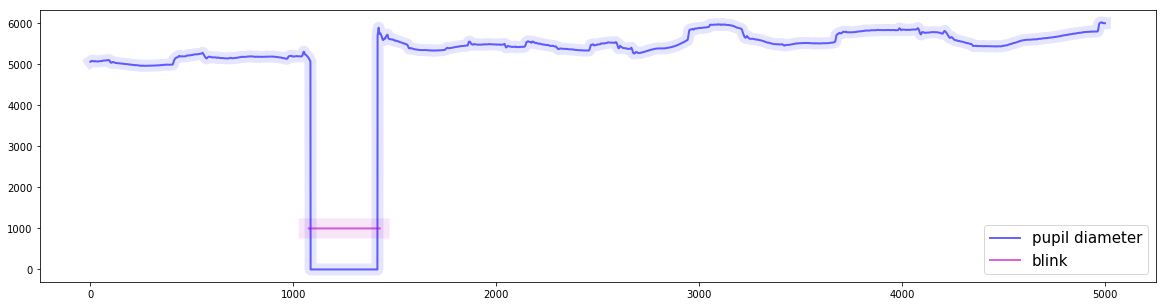

In [9]:
plt.figure(figsize=[20, 5])
nice_lines(pupil[ind1:ind2], 'pupil diameter', 'b')
nice_lines(blinks[ind1:ind2], 'blink','m', light=[.1,20])
plt.legend(prop={'size': 15}, loc=4)

> we can load different subjects a couple of ways

In [13]:
i_subject = 5

In [ ]:
example = eyelink_data(i_subject)
example.extract_pupil_data()

collecting gaze data from: ../../collection/gaze_data/s05_d1.asc


In [ ]:
example = eyelink_data()
example.i_subject = i_subject
example.extract_pupil_data()